# COVID-19 ANALYSIS

This is an analysis of the COVID-19 pandemic in South Africa from March to August 2020

# Load libraries

In [1]:
from scipy.integrate import odeint
from datetime import datetime, date

import numpy as np
import pandas as pd
import seaborn as sns
from plotnine import *
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\zintl\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\zintl\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\zintl\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


# Load data

In [2]:
#national_report = pd.read_csv('../data/nicd_daily_national_report.csv')
confirmed = pd.read_csv(
    'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_confirmed.csv')
recoveries = pd.read_csv(
    'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_recoveries.csv')
deaths = pd.read_csv(
    'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_deaths.csv')
transmission = pd.read_csv(
    'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_timeline_transmission_type.csv')
hospitals = pd.read_csv(
    'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/health_system_za_hospitals_v1.csv')

In [3]:
confirmed['date'] = pd.to_datetime(confirmed['date'], format='%d-%m-%Y')
confirmed.tail(3)

,date,YYYYMMDD,EC,FS,GP,KZN,LP,MP,NC,NW,WC,UNKNOWN,total,source
177,2020-08-31,20200831,86163.0,37888.0,210169.0,113006.0,13265.0,24405.0,10726.0,25348.0,106021.0,50.0,627041,https://sacoronavirus.co.za/2020/08/31/update-...
178,2020-09-01,20200901,86217.0,38125.0,210518.0,113237.0,13301.0,24470.0,10837.0,25390.0,106114.0,50.0,628259,https://sacoronavirus.co.za/2020/09/01/update-...
179,2020-09-02,20200902,86322.0,38473.0,211157.0,113661.0,13400.0,24605.0,11020.0,25604.0,106353.0,0.0,630595,https://twitter.com/nicd_sa/status/13012465363...


In [4]:
recoveries['date'] = pd.to_datetime(recoveries['date'], format='%d-%m-%Y')
recoveries.tail(3)

,date,YYYYMMDD,EC,FS,GP,KZN,LP,MP,NC,NW,WC,UNKNOWN,total,source
130,2020-08-31,20200831,81373,23180,182466,95993,12398,22738,7003,18636,97136,0,540923,https://twitter.com/nicd_sa/status/13005243515...
131,2020-09-01,20200901,82233,24464,183789,100384,12486,22939,7175,18886,97637,0,549993,https://twitter.com/nicd_sa/status/13008860476...
132,2020-09-02,20200902,82233,25999,184274,100605,12486,23004,7420,19388,98047,0,553456,https://twitter.com/nicd_sa/status/13012465363...


In [5]:
deaths['date'] = pd.to_datetime(deaths['date'], format='%d-%m-%Y')
deaths.tail(3)

,date,YYYYMMDD,EC,FS,GP,KZN,LP,MP,NC,NW,WC,UNKNOWN,total,source
153,2020-08-31,20200831,2896,709,3592,2139,202,341,129,248,3893,0,14149,https://twitter.com/nicd_sa/status/13005243515...
154,2020-09-01,20200901,2903,716,3631,2152,202,351,129,266,3913,0,14263,https://twitter.com/nicd_sa/status/13008860476...
155,2020-09-02,20200902,2932,731,3680,2164,202,351,134,266,3929,0,14389,https://twitter.com/nicd_sa/status/13012465363...


In [6]:
transmission = transmission.drop(['Unnamed: 4'], axis = 1)
transmission.head(2)

,case_id,transmission_type,type,countries
0,1,Travelled to Italy,travel,italy
1,2,Travelled to Italy,travel,italy


Create a new dataframe with the total number of confirmed positive cases, recoveries and deaths.

In [7]:
# combine the number of cases into a new dataframe
total_cases = pd.concat([confirmed['date'], confirmed['total'],
                         recoveries['total'], deaths['total']], axis=1)

# rename columns
total_cases['confirmed'] = confirmed['total']
total_cases['recoveries'] = recoveries['total']
total_cases['deaths'] = deaths['total']

# convert date column from string to datetime
total_cases['date'] = pd.to_datetime(total_cases['date'], format='%d-%m-%Y')

# drop the repeated columns
total_cases = total_cases.drop(['total', 'total', 'total'], axis=1)

# shift rows down so that dates correspond
total_cases['recoveries'] = total_cases['recoveries'].shift(47)
total_cases['deaths'] = total_cases['deaths'].shift(24)

# fill NAs with zeros
total_cases['recoveries'] = total_cases['recoveries'].fillna(0)
total_cases['deaths'] = total_cases['deaths'].fillna(0)

In [8]:
total_cases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        180 non-null    datetime64[ns]
 1   confirmed   180 non-null    int64         
 2   recoveries  180 non-null    float64       
 3   deaths      180 non-null    float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 5.8 KB


In [9]:
# calculate recovery and deaths rates, and create new columns
total_cases['recov_rate'] = (total_cases['recoveries']/total_cases['confirmed'])*100
total_cases['death_rate'] = (total_cases['deaths']/total_cases['confirmed'])*100

# create a month column
total_cases['month'] = total_cases['date'].dt.month

# change month number to month name
total_cases['month'] = total_cases['month'].replace(3, 'March')
total_cases['month'] = total_cases['month'].replace(4, 'April')
total_cases['month'] = total_cases['month'].replace(5, 'May')
total_cases['month'] = total_cases['month'].replace(6, 'June')
total_cases['month'] = total_cases['month'].replace(7, 'July')
total_cases['month'] = total_cases['month'].replace(8, 'August')

In [10]:
# create a dataframe with confirmed cases
confirmed_cases = pd.melt(total_cases, id_vars=['date', 'month'], value_vars=['confirmed', 'recoveries', 'deaths'])

# create a dataframe with death and recovery rates
death_recovery = pd.melt(total_cases, id_vars=['date', 'month'], value_vars=['recov_rate', 'death_rate'])

In [11]:
confirmed_cases.tail(), death_recovery.tail()

(          date   month variable    value
 535 2020-08-29  August   deaths  13981.0
 536 2020-08-30  August   deaths  14028.0
 537 2020-08-31  August   deaths  14149.0
 538 2020-09-01       9   deaths  14263.0
 539 2020-09-02       9   deaths  14389.0,
           date   month    variable     value
 355 2020-08-29  August  death_rate  2.245760
 356 2020-08-30  August  death_rate  2.244279
 357 2020-08-31  August  death_rate  2.256471
 358 2020-09-01       9  death_rate  2.270242
 359 2020-09-02       9  death_rate  2.281813)

Recoveries were recorded only 47 days after the first positive case was confirmed, and deaths were first reported after 24 days. To date there are 525 242 recoveries and 13 502 deaths. 

# Data analysis

## Number of cases in South Africa

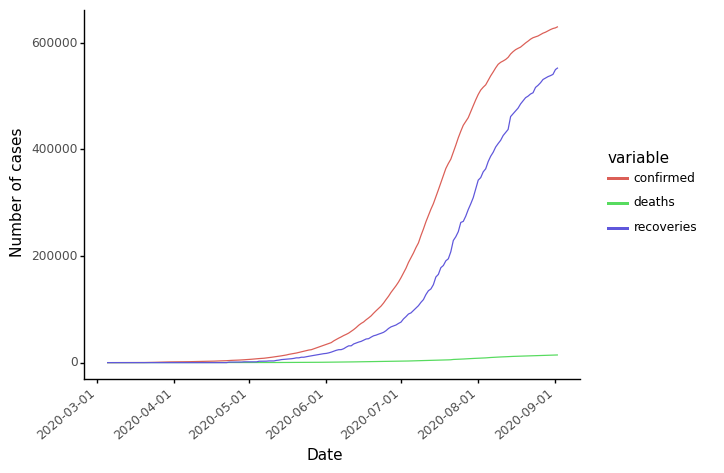

<ggplot: (188993623104)>

In [52]:
(ggplot(confirmed_cases, aes(x='date', y='value', color='variable'))
    + geom_line()
    + labs(x='Date', y='Number of cases')
    + theme_classic()
    + theme(axis_text_x=element_text(rotation=40, hjust=1))
 )

On the 15th of March the president declared a national state of disaster and prohibited large gatherings. This was followed by a strict lockdown (Level 5). At this point the number of positive cases was at a minimum. We experienced a spike in positive cases between the beginning of June and mid-August, during Level 3 of lockdown.

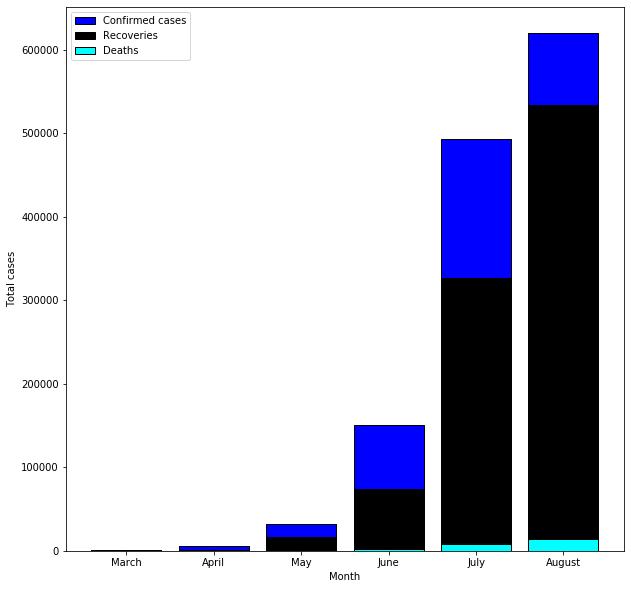

In [60]:
# set figure size
plt.figure(figsize=(10, 10))

# plot all cases in a bar graph
plt.bar(total_cases['month'], total_cases['confirmed'],
        color='blue', edgecolor='black', label='Confirmed cases')
plt.bar(total_cases['month'], total_cases['recoveries'],
        color='black', edgecolor='black', label='Recoveries')
plt.bar(total_cases['month'], total_cases['deaths'],
        color='cyan', edgecolor='black', label='Deaths')

# show the legend
plt.legend()
# set axis labels
plt.ylabel('Total cases')
plt.xlabel('Month')

plt.show()

More positive cases were reported from June to July. There has been a positive increase in recoveries and a small proportion of confirmed cases resulted in death.

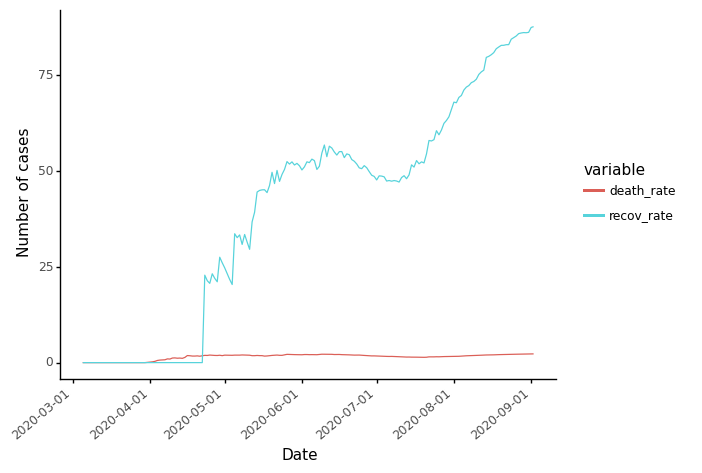

<ggplot: (188993927730)>

In [48]:
(ggplot(death_recovery, aes(x='date', y='value', color='variable'))
    + geom_line()
    + labs(x='Date', y='Number of cases')
    + theme_classic()
    + theme(axis_text_x=element_text(rotation=40, hjust=1))
 )

Even with the exponential increase in confirmed cases the death rate has been minimal, with only 2.2% of COVID related deaths being reported to date.

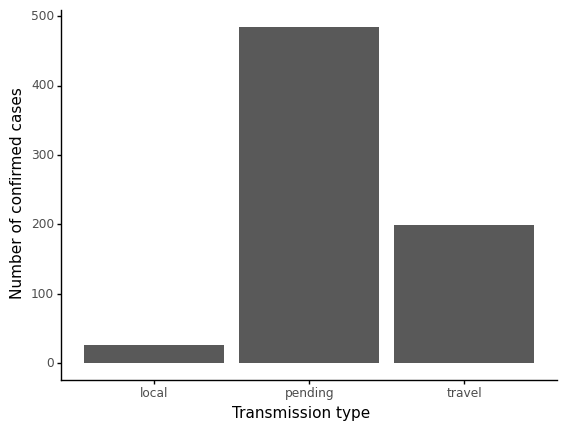

<ggplot: (-9223371851074281237)>

In [32]:
(ggplot(transmission, aes(x='type'))
 + geom_bar()
 + theme_classic()
 + xlab('Transmission type')
 + ylab('Number of confirmed cases')
)

An analysis of cases reported in mid-March (25 March 2020) showed that more people who tested positive for the virus had travelled abroad and contracted the virus in that period. This was before the travel ban was implemented. 

## Number of cases by province

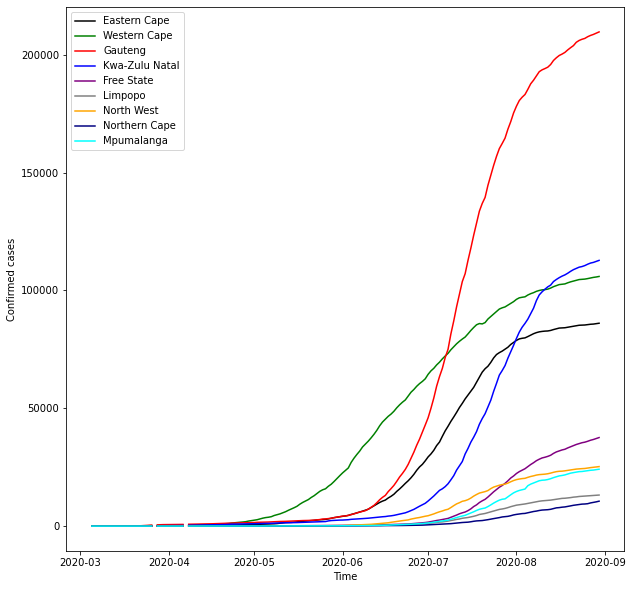

In [196]:
plt.figure(figsize=(10,10))

plt.plot(confirmed['date'], confirmed['EC'],
         color='black', label='Eastern Cape')
plt.plot(confirmed['date'], confirmed['WC'],
         color='green', label='Western Cape')
plt.plot(confirmed['date'], confirmed['GP'],
         color='red', label='Gauteng')
plt.plot(confirmed['date'], confirmed['KZN'],
         color='blue', label='Kwa-Zulu Natal')
plt.plot(confirmed['date'], confirmed['FS'],
         color='purple', label='Free State')
plt.plot(confirmed['date'], confirmed['LP'],
         color='grey', label='Limpopo')
plt.plot(confirmed['date'], confirmed['NW'],
         color='orange', label='North West')
plt.plot(confirmed['date'], confirmed['NC'],
         color='navy', label='Northern Cape')
plt.plot(confirmed['date'], confirmed['MP'],
         color='cyan', label='Mpumalanga')

# show the legend
plt.legend()
# set axis labels
plt.ylabel('Confirmed cases')
plt.xlabel('Time')

plt.show()

Gauteng, KZN, the Eastern Cape and the Western Cape have the highest positive cases in the country.

In [12]:
reproductive_rate = pd.read_csv(
    'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/calc/calculated_rt_sa_provincial_cumulative.csv')

In [13]:
reproductive_rate['date'] = pd.to_datetime(reproductive_rate['date'], format='%Y-%m-%d')

total = reproductive_rate[reproductive_rate['state'] == 'Total RSA']
total.tail()

,state,date,ML,High_90,Low_90
1025,Total RSA,2020-08-06,1.18,1.30,1.04
1026,Total RSA,2020-08-07,0.97,1.09,0.83
1027,Total RSA,2020-08-08,0.82,0.93,0.66
1028,Total RSA,2020-08-09,0.48,0.60,0.32
1029,Total RSA,2020-08-10,0.40,0.52,0.23


## Effective reproductive number ($R_t$)

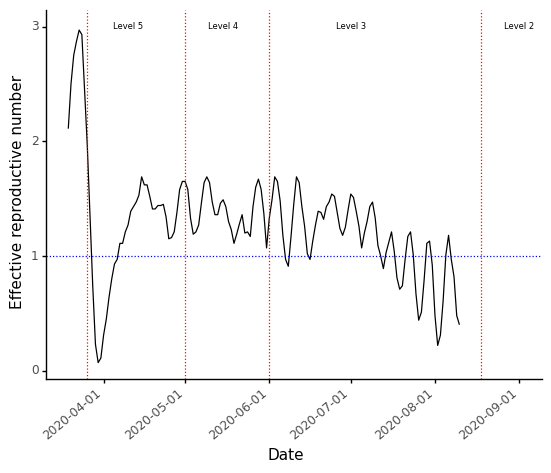

<ggplot: (-9223371847860858957)>

In [47]:
(ggplot(total, aes(x='date', y='ML'))
    + geom_line()
    + labs(x='Date', y='Effective reproductive number')
    + geom_hline(yintercept=1, linetype='dotted', color='blue')
    + geom_vline(xintercept=['2020-03-26', '2020-05-01',
                             '2020-06-01', '2020-08-18'], linetype='dotted', color='red')
    + annotate('text', x='2020-04-10', y=3, label='Level 5', size=6)
    + annotate('text', x='2020-05-15', y=3, label='Level 4', size=6)
    + annotate('text', x='2020-07-01', y=3, label='Level 3', size=6)
    + annotate('text', x='2020-09-01', y=3, label='Level 2', size=6)
    + theme_classic()
    + theme(axis_text_x=element_text(rotation=40, hjust=1))
 )

The effective reproductive number ($R_t$) of a virus indicates how infectious it is. It helps in eastimating how many people will contract the virus from one person who is infected at time t. If the $R_t$ value is above 1 that indicates that the virus is highly contagious and will likely result in an epidemic. The $R_t$ for coronavirus increased up to 3 before the lockdown was implemented. After lockdown restrictions were implemented the reproductive number remained between 1 and 2. Towards the end of level 3 lockdown the reproductive number decreased below 1 suggesting a decline in infection rates.

## Mobility report

In [14]:
mobility = pd.read_csv(
    'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/mobility/google_mobility/mobility_report_ZA.csv')

In [27]:
mobility.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 193 entries, 0 to 192
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   province               193 non-null    object        
 1   date                   193 non-null    datetime64[ns]
 2   retail and recreation  193 non-null    float64       
 3   grocery and pharmacy   193 non-null    float64       
 4   parks                  193 non-null    float64       
 5   transit stations       193 non-null    float64       
 6   workplaces             193 non-null    float64       
 7   residential            193 non-null    float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 13.6+ KB


In [20]:
mobility = mobility[mobility['province'] == 'Total']
mobility['date'] = pd.to_datetime(mobility['date'], format='%Y-%m-%d')

mobility = pd.melt(mobility, id_vars=['province', 'date'], 
                   value_vars=['retail and recreation', 
                               'grocery and pharmacy', 'parks', 
                               'transit stations', 'workplaces', 
                               'residential'])

In [30]:
mobility.head()

,province,date,variable,value
0,Total,2020-02-15,retail and recreation,4.0
1,Total,2020-02-16,retail and recreation,-3.0
2,Total,2020-02-17,retail and recreation,-10.0
3,Total,2020-02-18,retail and recreation,-12.0
4,Total,2020-02-19,retail and recreation,-12.0


This is a report that illustrates responses to social distancing during Covid-19 prepared by Google. The report shows changes in visits and length of stay in various public places (e.g restuarants, parks, grocery stores) compared to a baseline (0). 

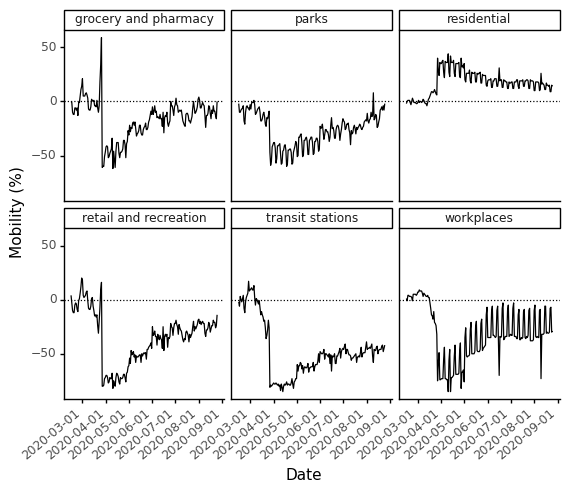

<ggplot: (-9223371847860185102)>

In [46]:
(ggplot(mobility, aes(x='date', y='value'))
    + geom_line()
    + facet_wrap('variable')
    + geom_hline(yintercept=0, linetype='dotted')
    + theme_classic()
    + theme(axis_text_x=element_text(rotation=40, hjust=1))
    + labs(x = 'Date', y = 'Mobility (%)')
)

Since the start of lockdown there has been a decrease in the number of visits to public areas. As lockdown restrictions were eased people started going out in public and spending less time at home.

# SIR Modelling

In order to model the spread of the virus without any lockdown interventions or social distancing we need to use the SIR model which requires the following parameters:
* *S* - the number of **susceptible** individuals. The assumption is that everyone in the population is susceptible and can   be infected
* *I* - the number of **infected** individuals who can spread the virus
* *R* - the number of **removed** individuals who have either passed away or recovered and cannot be reinfected

Two epidemiological quantities are also needed: the reproductive number and the recovery rate. The reproductive number of the virus when the first case was reported was 2.07. At the moment the model does not account for lockdown and travel restrictions.\
These are the basic equations that the model is built on:
* $\frac{dS}{dt}=-\beta.I.\frac{S}{N}$


* $\frac{dI}{dt}=\beta.I.\frac{S}{N} - \gamma.I$


* $\frac{dR}{dt}=\gamma.I$

The model assumes that the population stays the same and does not account for births and deaths that are not Covid-19 related.\
The code for this model was obtained from scipython.com.

In [30]:
# total population
N = 36196938

# recoveries & active infections
I0 = 1
R0 = 0

# susceptible
S0 = N - I0 - R0

# reproductive number
B = 2.07

# recovery rate
G = 1/5

# set the number of days to 250
t = range(0, 40)

In [31]:
# SIR model differential equations
def derivative(y, t, N, B, G):
    S, I, R = y
    dSdt = -B * S * I / N
    dIdt = B * S * I / N - G * I
    dRdt = G * I
    return dSdt, dIdt, dRdt

In [32]:
# initial conditions
y0 = S0, I0, R0
ret = odeint(derivative, y0, t, args=(N, B, G))
S, I, R = ret.T

# create a dataframe for S, I and R
infection_model = pd.DataFrame(
    {'susceptible': S,
     'infected': I,
     'recovered': R,
     'days': t})

In [205]:
infection_model.tail()

,susceptible,infected,recovered,days
245,0.000015,2.835992,5.943100e+07,245
246,0.000015,2.640486,5.943100e+07,246
247,0.000015,2.458459,5.943100e+07,247
248,0.000015,2.288979,5.943100e+07,248
249,0.000015,2.131183,5.943100e+07,249


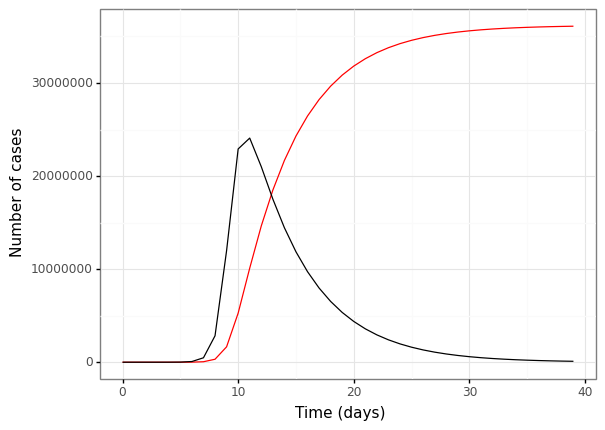

<ggplot: (-9223371917299632892)>

In [33]:
ggplot(infection_model, aes(x='days')) + \
    geom_line(aes(y='recovered'), color='red') + \
    geom_line(aes(y='infected'), color='black') + \
    xlab('Time (days)') + \
    ylab('Number of cases') + \
    theme_bw() + \
    theme()

# References